In [2]:
# 1) Environment setup
!pip install pyspark findspark matplotlib seaborn pandas

In [16]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, length, isnan, when, count

from pyspark.sql.types import DoubleType, FloatType

import matplotlib.pyplot as plt
import seaborn as sns


In [11]:
spark = SparkSession.builder \
    .appName("AmazonReviewsExploration") \
    .getOrCreate()

# Load full JSONL, then sample 1% for exploration:
reviews = spark.read.json("/content/All_Beauty.jsonl")

In [15]:
# 3.1 Shape & Schema
print(f"Total reviews: {reviews.count()}")
reviews.printSchema()

# 3.2 Missing / Null counts per column
def null_counts(df):
    exprs = []
    for fld in df.schema.fields:
        name = fld.name
        dt   = fld.dataType
        if isinstance(dt, (DoubleType, FloatType)):
            exprs.append(
                count(when(col(name).isNull() | isnan(col(name)), name))
                .alias(name)
            )
        else:
            exprs.append(
                count(when(col(name).isNull(), name))
                .alias(name)
            )
    return df.select(exprs)

print("Review nulls:")
null_counts(reviews).show()

# 3.3 Summary statistics (numeric & string lengths)
reviews.select("rating").describe().show()

# add a text-length column
reviews = reviews.withColumn("text_len", length(col("text")))
reviews.select("text_len").describe().show()

# 3.4 Value counts: rating & verified_purchase
reviews.groupBy("rating").count().orderBy("rating").show()
reviews.groupBy("verified_purchase").count().show()

Total reviews: 701528
root
 |-- asin: string (nullable = true)
 |-- helpful_vote: long (nullable = true)
 |-- images: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- attachment_type: string (nullable = true)
 |    |    |-- large_image_url: string (nullable = true)
 |    |    |-- medium_image_url: string (nullable = true)
 |    |    |-- small_image_url: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- text: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- title: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- verified_purchase: boolean (nullable = true)

Review nulls:
+----+------------+------+-----------+------+----+---------+-----+-------+-----------------+
|asin|helpful_vote|images|parent_asin|rating|text|timestamp|title|user_id|verified_purchase|
+----+------------+------+-----------+------+----+---------+-----+-------+-----------------+
|   0

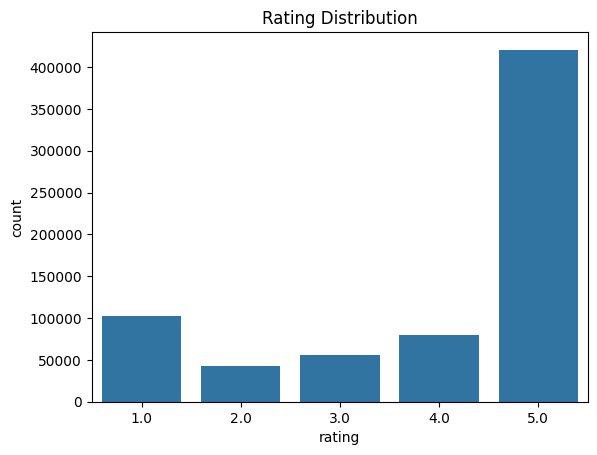

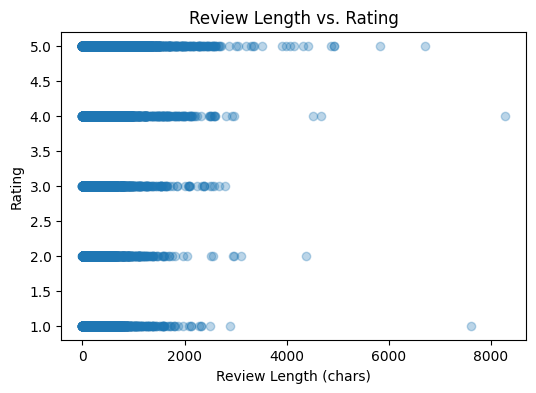

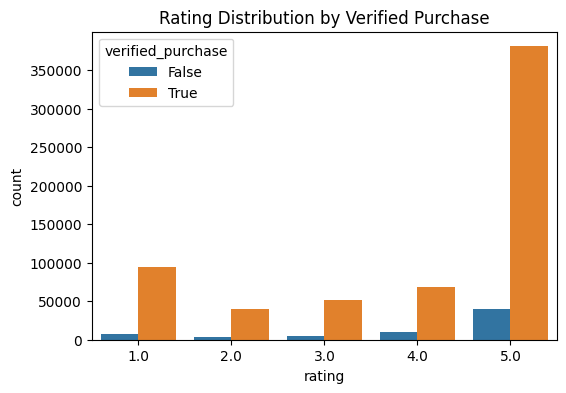

In [20]:
# Ratings histogram
pdf = reviews.groupBy("rating") \
    .count() \
    .orderBy("rating") \
    .toPandas()
sns.barplot(x="rating", y="count", data=pdf)
plt.title("Rating Distribution")
plt.show()

# Scatter: Review length vs. Rating
scatter_pdf = (
    reviews
      .select("text_len","rating")
      .dropna()
      .sample(False, 0.1, seed=1)
      .toPandas()
)
plt.figure(figsize=(6,4))
plt.scatter(scatter_pdf["text_len"], scatter_pdf["rating"], alpha=0.3)
plt.xlabel("Review Length (chars)")
plt.ylabel("Rating")
plt.title("Review Length vs. Rating")
plt.show()

# Verified vs. Unverifies Purchase Ratings
verif_pdf = (
    reviews
      .groupBy("verified_purchase", "rating")
      .count()
      .toPandas()
)
plt.figure(figsize=(6,4))
sns.barplot(
    x="rating", y="count", hue="verified_purchase",
    data=verif_pdf
)
plt.title("Rating Distribution by Verified Purchase")
plt.show()


Link to download data (All_Beauty category only for now): https://mcauleylab.ucsd.edu/public_datasets/data/amazon_2023/raw/review_categories/All_Beauty.jsonl.gz